This notebook reproduces the empirical example from

Dudda, Tom; Klein, Tony; Walther, Thomas (2021): Schätzung und Vorhersage „Realisierter Volatilität“, in: WiSt – Wirtschaftswissenschaftliches Studium, Vol. 50, Nr. 4, pp. 19-25. DOI: 10.15358/0340-1650-2021-4-19.

In [1]:
# packages to load
import numpy as np
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

We use the data from

Heber, Gerd, Asger Lunde, Neil Shephard and Kevin Sheppard (2009) "Oxford-Man Institute's realized library", Oxford-Man Institute, University of Oxford.

Library version 0.3


In [2]:
# load data
RV = pd.read_csv('https://realized.oxford-man.ox.ac.uk/images/oxfordmanrealizedvolatilityindices.zip', compression='zip')
# First column Date index
RV.rename(columns={'Unnamed: 0':'Date'}, inplace=True)
RV['Date'] = pd.to_datetime(RV['Date'], utc=True).dt.date

# Extract only 5min RV as single DataFrame with columns for each Stock index
RV5min = RV.pivot_table(index=['Date'], 
            columns=['Symbol'], values='rv5')
Prices = RV.pivot_table(index=['Date'], 
            columns=['Symbol'], values='close_price')

In [3]:
# Build DataFrame for DAX with 5min RVs for 1, 5, and 22 days (averages) and drop NaNs
daxrv = pd.DataFrame(columns={'RV1'})
daxrv['RV1'] = np.sqrt(RV5min['.GDAXI'].dropna(0))
daxrv['RV5'] = daxrv['RV1'].rolling(5,5).mean()
daxrv['RV22'] = daxrv['RV1'].rolling(22,22).mean()
print(len(daxrv))
daxrv = daxrv.dropna(0)

5339


In [4]:
daxrv=daxrv.set_index(pd.to_datetime(daxrv.index))
daxrv.sort_index(inplace=True, ascending=True)
daxrv=daxrv.loc['2000-02-01':'2020-06-25']
len(daxrv)

5170

In [5]:
Y1 = daxrv['RV1'][1:].reset_index(drop=True)
X1 = daxrv.shift(1).iloc[1:,].reset_index(drop=True)
Y5 = daxrv['RV1'][5:].reset_index(drop=True)
X5 = daxrv.shift(5).iloc[5:,].reset_index(drop=True)
Y22 = daxrv['RV1'][22:].reset_index(drop=True)
X22 = daxrv.shift(22).iloc[22:,].reset_index(drop=True)

In [6]:
model = sm.OLS(Y1,sm.add_constant(X1))
results = model.fit(cov_type='HC3')
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RV1   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     1253.
Date:                Thu, 28 Jan 2021   Prob (F-statistic):               0.00
Time:                        15:12:32   Log-Likelihood:                 21844.
No. Observations:                5169   AIC:                        -4.368e+04
Df Residuals:                    5165   BIC:                        -4.365e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      3.861      0.000       0.000       0.001
RV1            0.3930      0.042      9.450      0.000       0.311       0.474
RV5            0.4050      0.057      7.088      0.000       0.293       0.517
RV22           0.1500      0.039      3.865      0.000       0.074       0.226
==============================================================================
Omnibus:                     3834.473   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           241887.957
Skew:                           2.956   Prob(JB):                         0.00
Kurtosis:                      35.987   Cond. No.                         634.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [7]:
results.HC3_se

const    0.000145
RV1      0.041585
RV5      0.057134
RV22     0.038793
dtype: float64

In [8]:
WindowL = 1000
Y = Y1
X = X1
Nfor = len(Y)-WindowL
RVfc = pd.DataFrame()

fc = np.zeros(Nfor)
for i in range(Nfor):
    print('\r'+str(i), end='')
    Yh = Y[i:i+WindowL]
    Xh = X.iloc[i:i+WindowL,:]
    model = sm.OLS(Yh,sm.add_constant(Xh))
    results = model.fit()
    Xf = daxrv.iloc[i:i+WindowL+1,].reset_index(drop=True)
    fore = results.predict(sm.add_constant(Xf))
    fc[i] = fore[len(fore)-1]

4168

Text(0.5, 0, '')

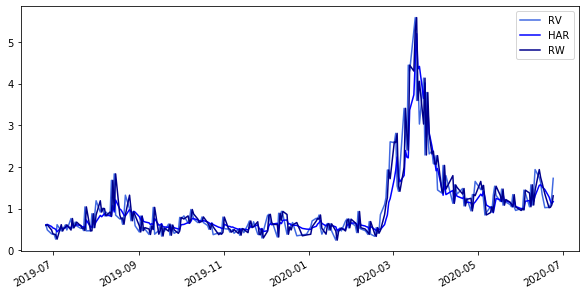

In [10]:
from matplotlib import cm
cmap = cm.get_cmap("Blues")
comp = pd.DataFrame({'RV':np.array(Y[-Nfor:])*100, 'HAR':fc*100, 'RW':np.array(Y[-Nfor-1:-1])*100}, index=daxrv.index[-Nfor:])
ax = comp.iloc[-250:-1,[0,1,2]].plot(figsize=(10,5), color=["royalblue", "blue", "darkblue"])
ax.set_xlabel("")
# plt.savefig('forecast.png', bbox_inches='tight')
# plt.savefig(forecast.eps', bbox_inches='tight')

In [11]:
RMSE = np.sqrt(np.mean((np.array(Y[-Nfor:])*100-fc*100)**2))
print('RMSE %1.4f' %RMSE)
MAPE = np.mean(np.abs(fc/np.array(Y[-Nfor:])-1))
print('MAPE %1.4f' %MAPE)
MAFE = np.mean(np.abs(np.array(Y[-Nfor:])*100-fc*100))
print('MAFE %1.4f' %MAFE)

RMSE 0.3177
MAPE 0.2225
MAFE 0.1989


In [12]:
RMSE = np.sqrt(np.mean((np.array(Y[-Nfor:])*100-np.array(Y[-Nfor-1:-1])*100)**2))
print('RMSE %1.4f' %RMSE)
MAPE = np.mean(np.abs(np.array(Y[-Nfor-1:-1])/np.array(Y[-Nfor:])-1))
print('MAPE %1.4f' %MAPE)
MAFE = np.mean(np.abs(np.array(Y[-Nfor:])*100-np.array(Y[-Nfor-1:-1])*100))
print('MAFE %1.4f' %MAFE)

RMSE 0.3523
MAPE 0.2437
MAFE 0.2249
